# Paddy Doctor

## Part One: Imports and Data Visualization
Here, import the required libraries for this project. Furthermore, we define some constants. Furthermore, we load the data and visualize it.

In [1]:
import tensorflow as tensorflow
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os, os.path
import csv
import tensorflow_hub as hub
from tqdm import tqdm

batch_size = 16
img_size = 224

In [2]:
train_categories = []
train_samples = []
train_path = 'dataset/train_images/'

for i in os.listdir(train_path):
    train_categories.append(i)
    train_samples.append(len(os.listdir(train_path + i)))

test_samples = []
test_path = 'dataset/test_images/'
for i in os.listdir(test_path):
    test_samples.append(test_path + i)

print("Count of images in Training set:", sum(train_samples))
print("Count of images in Set set:", len(test_samples))

Count of images in Training set: 10407
Count of images in Set set: 3469


Visualizing Distributions of Data

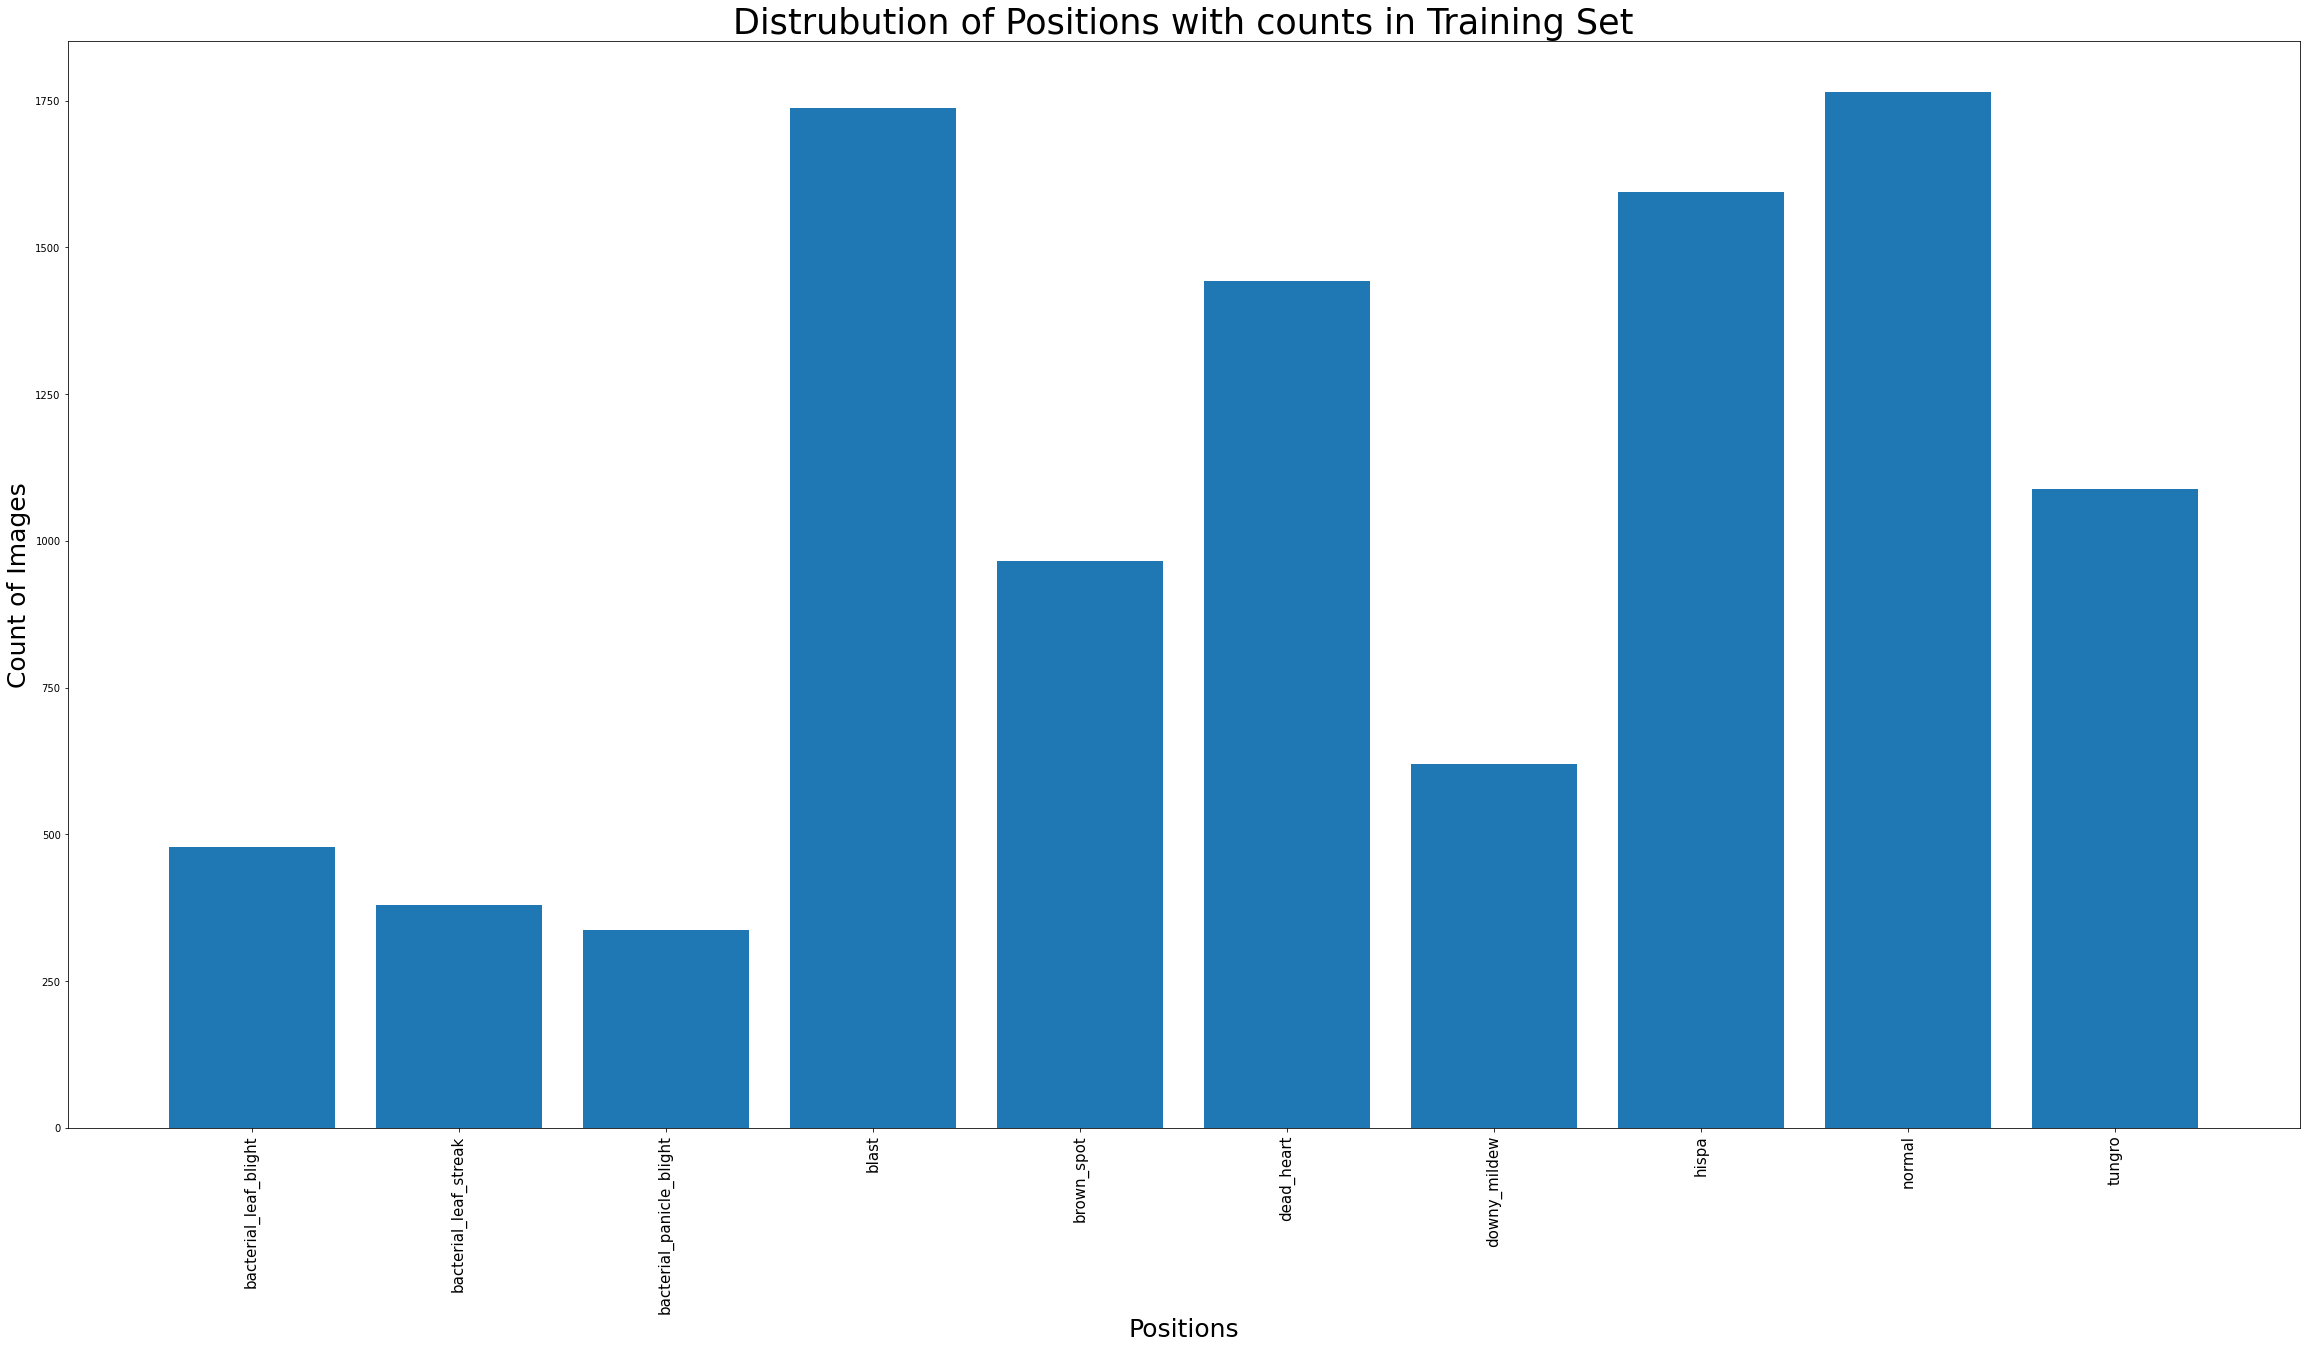

In [3]:
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size
index = np.arange(len(train_categories))
plt.bar(index, train_samples)
plt.xlabel('Positions', fontsize=25)
plt.ylabel('Count of Images', fontsize=25)
plt.xticks(index, train_categories, fontsize=15, rotation=90)
plt.title('Distrubution of Positions with counts in Training Set', fontsize=35)
plt.show()

Dictionary for labels

In [4]:
# Create a dictionary of labels and their corresponding index

label_to_index = dict(
    (name, index) for index, name in enumerate(train_categories))
print(label_to_index)

# Create a dictionary of index and their corresponding labels

index_to_label = dict(
    (index, name) for index, name in enumerate(train_categories))
print(index_to_label)

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
{0: 'bacterial_leaf_blight', 1: 'bacterial_leaf_streak', 2: 'bacterial_panicle_blight', 3: 'blast', 4: 'brown_spot', 5: 'dead_heart', 6: 'downy_mildew', 7: 'hispa', 8: 'normal', 9: 'tungro'}


Visualizing Individual Images

Found 10407 images belonging to 10 classes.


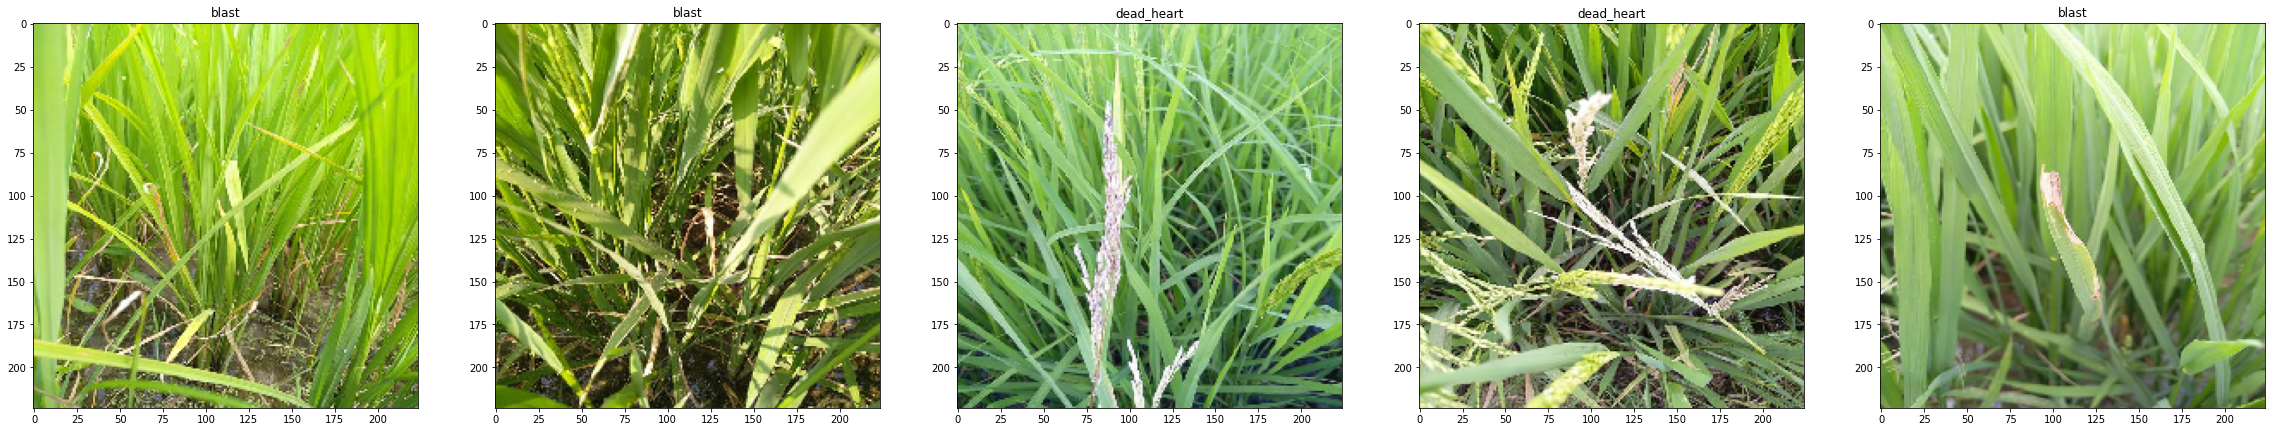

In [5]:
visualizer = ImageDataGenerator(rescale=1. / 255, )
dir_it = visualizer.flow_from_directory(train_path,
                                        target_size=(img_size, img_size),
                                        class_mode='categorical',
                                        batch_size=5,
                                        seed=100)

x_batch, y_batch = next(dir_it)

saved_image = x_batch[0]
# Resize to (1, 256, 256, 3)
saved_image = np.expand_dims(saved_image, axis=0)

for i in range(5):
    image = x_batch[i]
    label = y_batch[i]
    # Display the images side by side
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(index_to_label[np.argmax(label)])

Due to the nature of this dataset and the small amount of training material, we will be doing heavy data augmentation

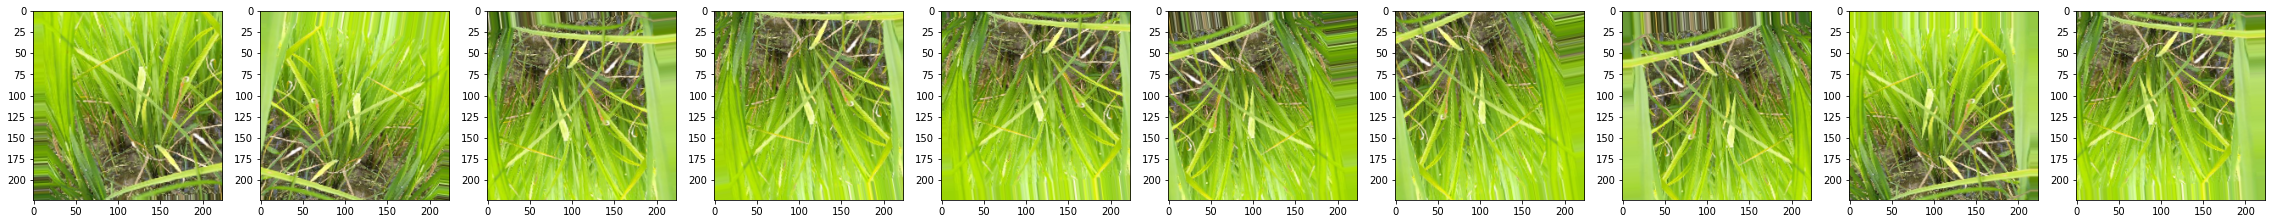

In [6]:
visualizer = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    validation_split=0.1,
    rotation_range=10,
    shear_range=0.25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

dir_it = visualizer.flow(
    saved_image,
    batch_size=1,
    seed=42,
)

# Get 10 augmented images of the first image
for i in range(10):
    x_batch = dir_it.next()
    image = x_batch[0]
    plt.subplot(1, 10, i + 1)
    plt.imshow(image)

## Part Two: Data Augmentation

Here we will be creating the augmented dataset we will be using

In [7]:
def get_dataset(path, batch_size, rescale, preprocess_function=None):
    aug_gens = ImageDataGenerator(
        rescale=rescale,  # normalize pixel values to [0,1]
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        shear_range=0.25,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.1,
        preprocessing_function=preprocess_function)

    train_data = aug_gens.flow_from_directory(path,
                                              target_size=(img_size, img_size),
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='training',
                                              seed=1447)

    val_data = aug_gens.flow_from_directory(path,
                                            target_size=(img_size, img_size),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            subset='validation',
                                            seed=1447)

    return train_data, val_data


train, val = get_dataset('dataset/train_images', batch_size, 1. / 255)


Found 9371 images belonging to 10 classes.
Found 1036 images belonging to 10 classes.


Here we can see that the dataset generator initialized correctly

In [8]:
print(train.classes)

[0 0 0 ... 9 9 9]


## Part Three: Basic Model
Here we will finally create our model!

We will start off with a very basic model to ensure everything is working!

In [9]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(img_size, img_size, 3)))
model.add(
    keras.layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        strides=(1, 1),
                        padding="same",
                        activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        padding="same",
                        activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=64,
                        kernel_size=(3, 3),
                        padding="same",
                        activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=128,
                        kernel_size=(3, 3),
                        padding="same",
                        activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1048, activation='swish'))
model.add(keras.layers.Dense(128, activation='swish'))
model.add(keras.layers.Dense(len(train_categories), activation='softmax'))

model.build(input_shape=(None, img_size, img_size, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

### Training
Now for the fun part. We first start off by compiling the model with the Adam optimizer, and set the number of epochs to 10. Then we fit the model and display the accuracies in a graph.

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
num_epochs = 10
history = model.fit(train,
                    workers=16,
                    epochs=num_epochs,
                    validation_data=val,
                    verbose=1)


Epoch 1/10
584/586 [============================>.] - ETA: 0s - loss: 1.9906 - accuracy: 0.2906

KeyboardInterrupt: 

### Visualization
Here, we will visualize the accuracy of the model as it trains.#

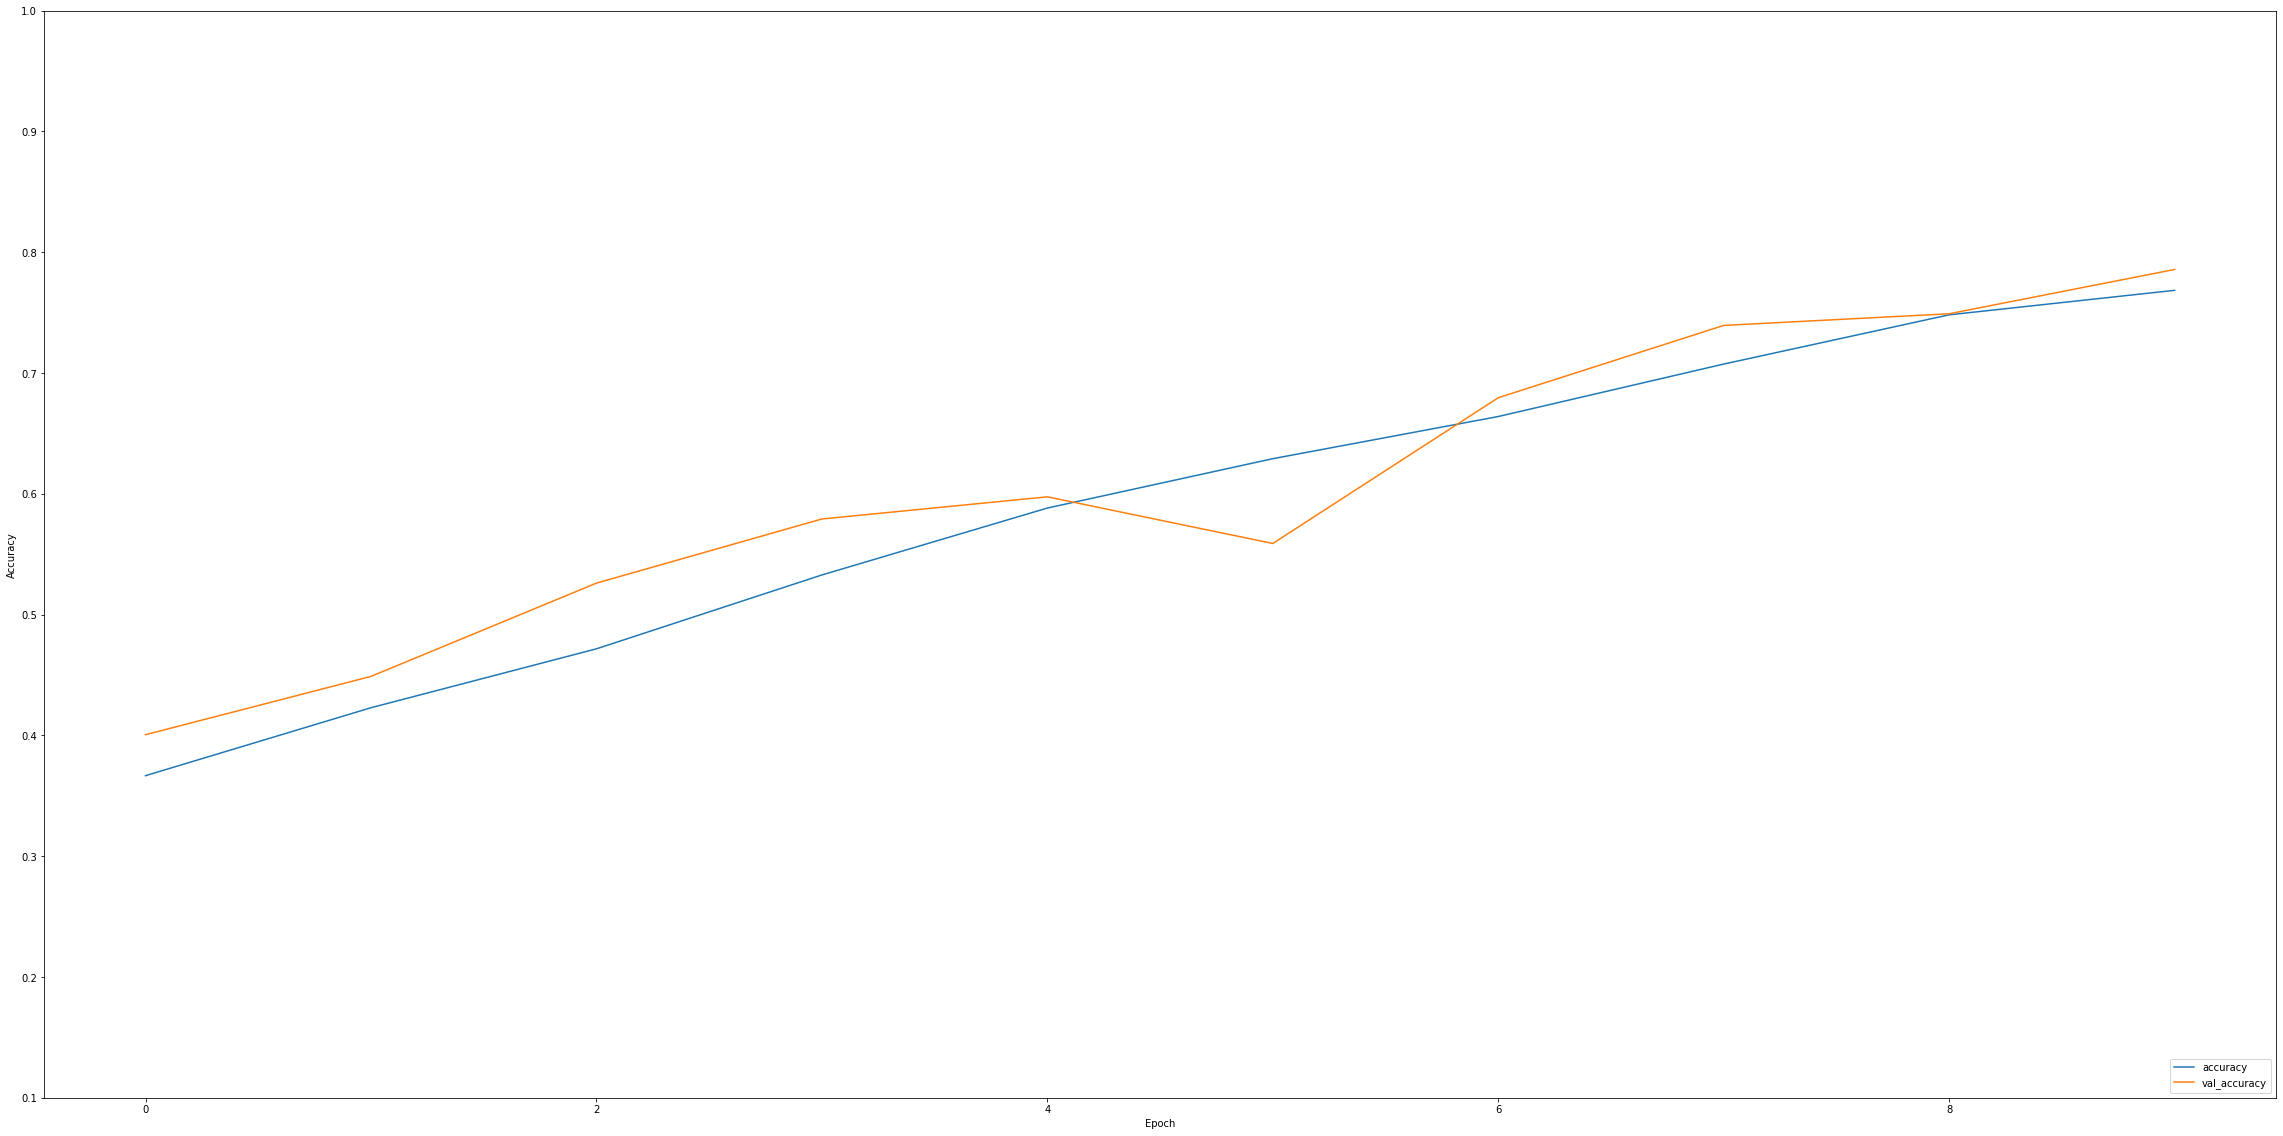

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

## Part Four: Advanced Model

Here we will utilize transfer learning with a pretrained model. We will be using the MobileNet V2 Model since it is small, efficient, and fast. We will also redefine the input due to EfficientNet expecting different preprocessing requirements.

In [ ]:
train, val = get_dataset(
    'dataset/train_images/',
    batch_size,
    1)


Found 9371 images belonging to 10 classes.
Found 1036 images belonging to 10 classes.


In [ ]:
mobNet = keras.applications.EfficientNetB4(input_shape=(img_size, img_size, 3),
                                           include_top=False,
                                           weights='imagenet',
                                           pooling='avg')
model = keras.models.Sequential()
model.add(keras.layers.Resizing(img_size, img_size, interpolation='bilinear'))
model.add(mobNet)
model.add(keras.layers.Dense(1024, activation='swish'))
model.add(keras.layers.Dense(128, activation='swish'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.build(input_shape=(None, img_size, img_size, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 dense (Dense)               (None, 1024)              1836032   
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 19,642,345
Trainable params: 19,517,138
Non-trainable params: 125,207
_________________________________________________________________


Again, we will compile the model. However, this time we will add three callbacks.

 - The first call back will be a learning rate reduction. This will reduce the learning rate upon a plateau in loss to prevent overfitting.
 - The second callback will be an early stopping callback. This call back will allow us to use a high number for epochs and yet the model will stop once it detects that the improvements have stopped.
 - The third callback will be a model checkpoint. This will allow us to save the model at the end of each epoch. This will allow us to use the best model for testing.

Once the three callbacks have been created, we will continue with training the model with the callbacks.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
num_epochs = 100

lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 patience=4,
                                                 verbose=1,
                                                 factor=0.4,
                                                 min_lr=0.0001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=0.00001,
                                           patience=8,
                                           mode='auto',
                                           restore_best_weights=True)

MCP = keras.callbacks.ModelCheckpoint('Best_points.h5',
                                      verbose=1,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max')

history = model.fit(train,
                    workers=16,
                    epochs=num_epochs,
                    validation_data=val,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[early_stop, lr_reduction, MCP])


Epoch 1/100
586/586 [==============================] - ETA: 0s - loss: 1.2048 - accuracy: 0.6051
Epoch 1: val_accuracy improved from -inf to 0.71042, saving model to Best_points.h5
586/586 [==============================] - 165s 253ms/step - loss: 1.2048 - accuracy: 0.6051 - val_loss: 1.0825 - val_accuracy: 0.7104 - lr: 0.0010
Epoch 2/100
586/586 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.7649
Epoch 2: val_accuracy improved from 0.71042 to 0.79247, saving model to Best_points.h5
586/586 [==============================] - 144s 245ms/step - loss: 0.7419 - accuracy: 0.7649 - val_loss: 0.6484 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 3/100
586/586 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.8280
Epoch 3: val_accuracy improved from 0.79247 to 0.84749, saving model to Best_points.h5
586/586 [==============================] - 145s 246ms/step - loss: 0.5462 - accuracy: 0.8280 - val_loss: 0.4424 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 4

KeyboardInterrupt: 

Our final validation accuracy is 97%! Thats really good for such a tough dataset!

### Visualizing Accuracy

Here we will visualize the accuracy of the model as it trains.

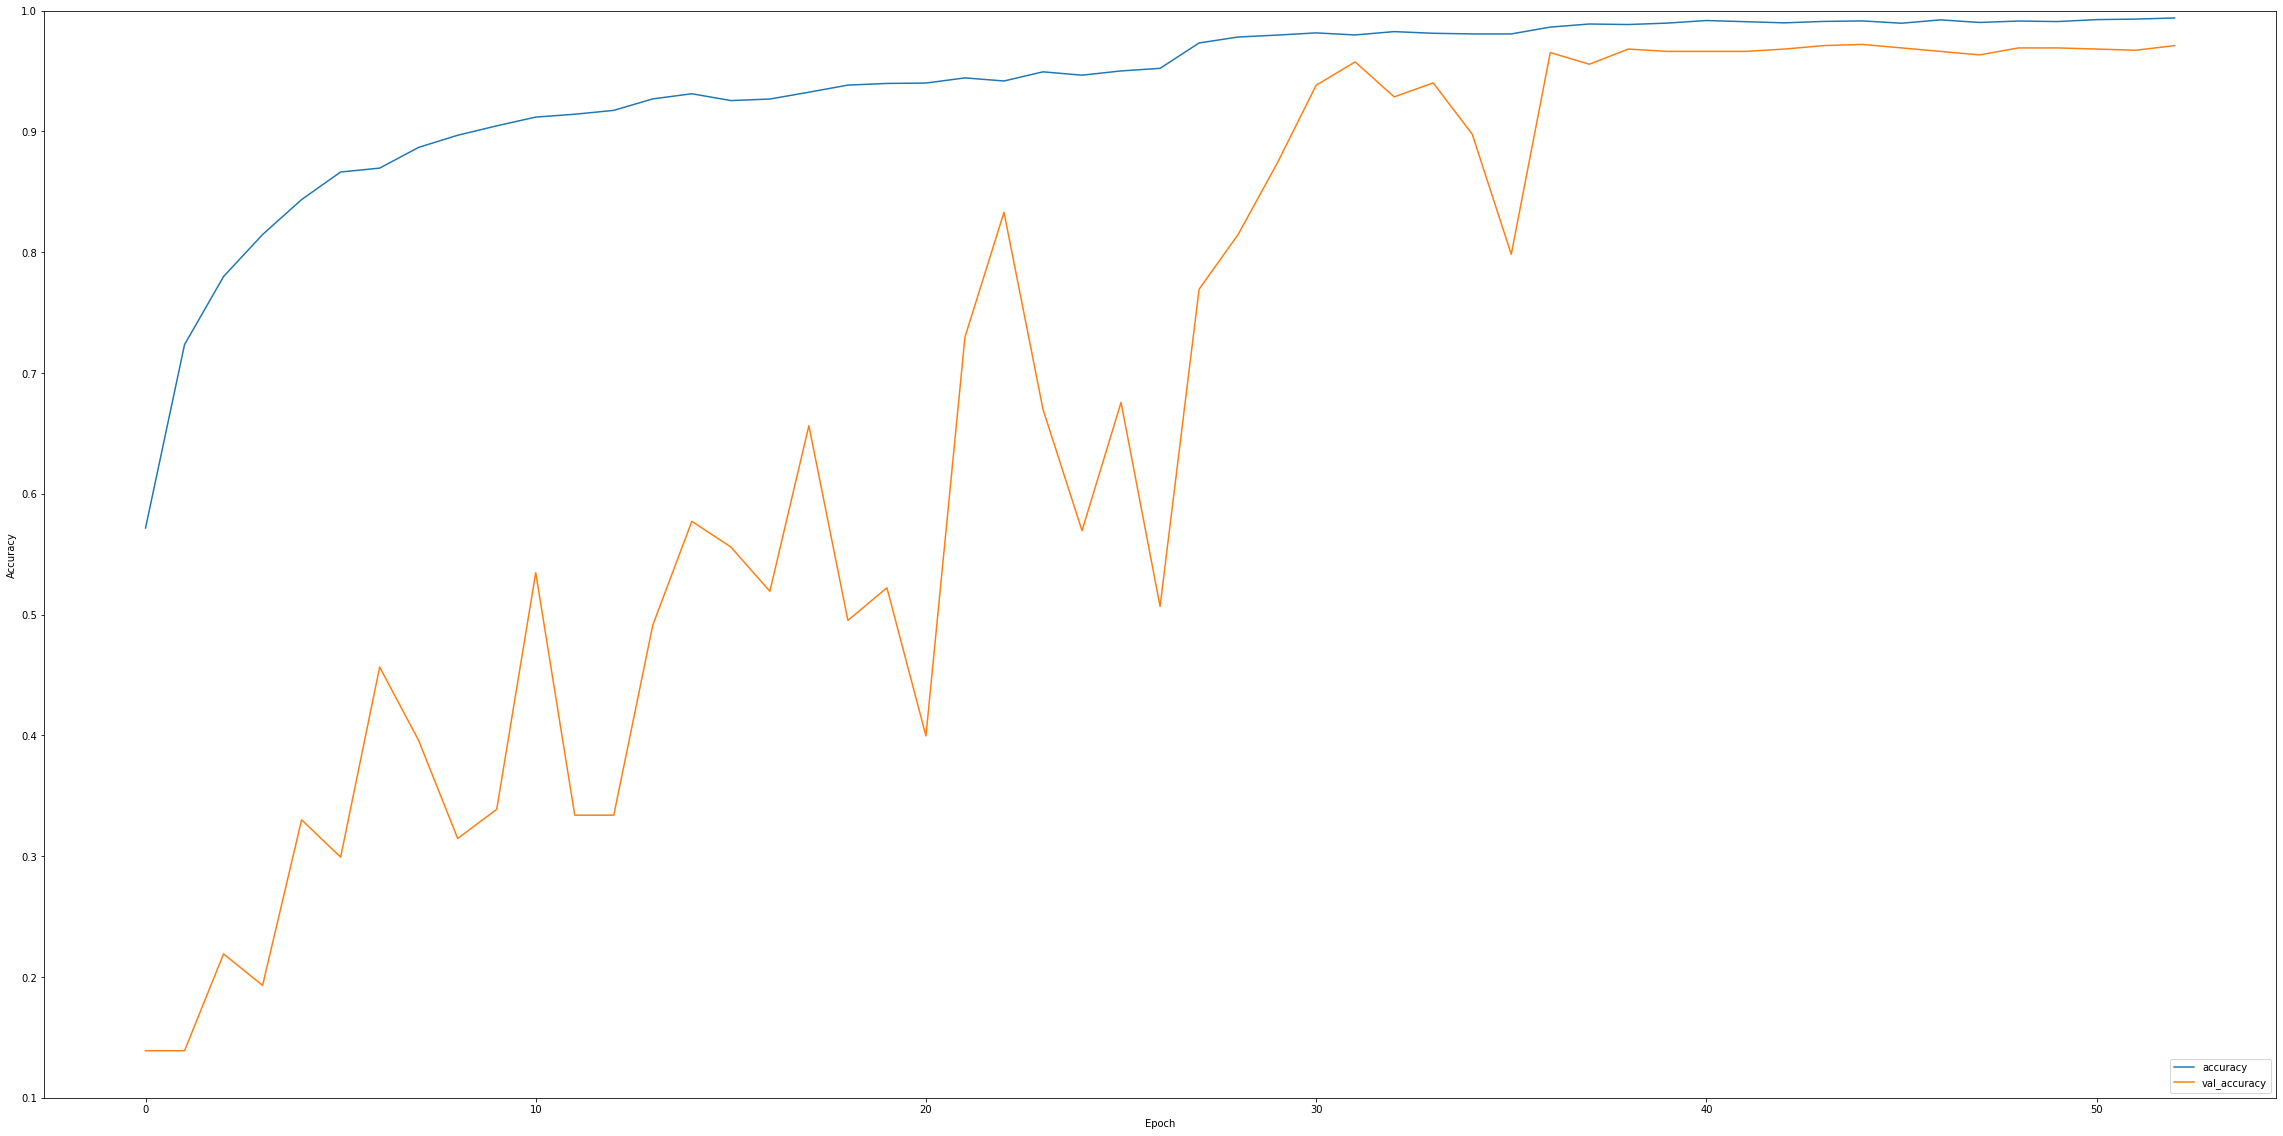

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

## Part Five: Saving the Model
First we load the model with the best weights

Then we save the model

In [ ]:
# Loading the model with the best weights
model.load_weights('Best_points.h5')

# Saving the model as a savedModel
model.save('model', save_format='tf')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


### Time Test Augmentation

Here we will use a technique called Time Test Augmentation to increase the accuracy of our model. This technique will allow us to use the same image multiple times and average the results. This will allow us to increase the accuracy of our model.

In [ ]:
predictions = []

aug_gens = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    shear_range=0.25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1,
)

for i in tqdm(range(10)):
    preds = model.predict(aug_gens.flow_from_directory(
        'dataset/train_images/',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=1447),
                          workers=16)
    predictions.append(preds)

final_pred = np.mean(predictions, axis=0)




  0%|          | 0/10 [00:00<?, ?it/s]

Found 1036 images belonging to 10 classes.
33/33 [==============================] - 3s 45ms/step


 10%|█         | 1/10 [00:03<00:27,  3.09s/it]

Found 1036 images belonging to 10 classes.
33/33 [==============================] - 2s 44ms/step


 20%|██        | 2/10 [00:05<00:21,  2.75s/it]

Found 1036 images belonging to 10 classes.
33/33 [==============================] - 2s 39ms/step


 30%|███       | 3/10 [00:07<00:17,  2.54s/it]

Found 1036 images belonging to 10 classes.
33/33 [==============================] - 2s 40ms/step


 40%|████      | 4/10 [00:10<00:14,  2.42s/it]

Found 1036 images belonging to 10 classes.
33/33 [==============================] - 2s 39ms/step


 50%|█████     | 5/10 [00:12<00:11,  2.36s/it]

Found 1036 images belonging to 10 classes.
33/33 [==============================] - 2s 39ms/step


 60%|██████    | 6/10 [00:14<00:09,  2.31s/it]

Found 1036 images belonging to 10 classes.
33/33 [==============================] - 2s 39ms/step


 70%|███████   | 7/10 [00:16<00:06,  2.27s/it]

Found 1036 images belonging to 10 classes.
33/33 [==============================] - 2s 39ms/step


 80%|████████  | 8/10 [00:18<00:04,  2.25s/it]

Found 1036 images belonging to 10 classes.
33/33 [==============================] - 2s 40ms/step


 90%|█████████ | 9/10 [00:21<00:02,  2.25s/it]

Found 1036 images belonging to 10 classes.
33/33 [==============================] - 2s 39ms/step


100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


In [ ]:
# Finding the index of the maximum value in each row
y_predict_max = np.argmax(final_pred, axis=1)
print(y_predict_max)

# Finding the actual labels in the val dataset
y_true = val.classes
print(y_true)

# Calculate accuracy
accuracy = 0
for i in range(len(y_true)):
    if y_true[i] == y_predict_max[i]:
        accuracy += 1

accuracy = accuracy / len(y_true)
print(accuracy)


[0 0 0 ... 9 9 9]
[0 0 0 ... 9 9 9]
0.9700772200772201


In [ ]:
model.evaluate(val, workers=16)

33/33 [==============================] - 2s 40ms/step - loss: 0.1552 - accuracy: 0.9662


[0.1552036553621292, 0.9662162065505981]

Since our validation accuracy was already pretty high, TTA will not increase the accuracy by much. However, it will still increase the accuracy by a small amount.